# Single-cell RNA-seq analysis workflow using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION. 

Licensed under the Apache License, Version 2.0 (the "License") 
you may not use this file except in compliance with the License. 
You may obtain a copy of the License at 

     http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software 
distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. 
See the License for the specific language governing permissions and 
limitations under the License.

In [41]:
%%bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   48 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          128
On-line CPU(s) list:             0-127
Vendor ID:                       AuthenticAMD
Model name:                      AMD Ryzen Threadripper PRO 5995WX 64-Cores
CPU family:                      25
Model:                           8
Thread(s) per core:              2
Core(s) per socket:              64
Socket(s):                       1
Stepping:                        2
Frequency boost:                 enabled
CPU max MHz:                     7024.2178
CPU min MHz:                     1800.0000
BogoMIPS:                        5390.13
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cp

## Import requirements

In [1]:
import time

import numpy as np
import scanpy as sc

import os, wget

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/krasnow_hlca_10x.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/krasnow_hlca_10x.sparse.h5ad',
                  input_file)

## Set parameters

In [3]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this 
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc.settings.n_jobs=16

In [4]:
start = time.time()

## Load Data

In [5]:
%%time
adata = sc.read(input_file)

CPU times: user 83.8 ms, sys: 287 ms, total: 371 ms
Wall time: 371 ms


## Preprocessing

In [6]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [7]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 884 ms, sys: 664 ms, total: 1.55 s
Wall time: 1.55 s


Some genes will now have zero expression in all cells. We filter out such genes.

In [8]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 740 ms, sys: 276 ms, total: 1.02 s
Wall time: 1.02 s


### Normalize

In [9]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 355 ms, sys: 38 ms, total: 393 ms
Wall time: 392 ms


In [10]:
%%time
sc.pp.log1p(adata)

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1.01 s


### Select Most Variable Genes

In [11]:
%%time
# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker+"_raw"]= adata.X[:, adata.var.index==marker].toarray()

adata = adata.copy()
n_genes = sum(adata.var.highly_variable)

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 1.01 s, sys: 76 ms, total: 1.08 s
Wall time: 1.08 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

In [12]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [13]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata[:, ribo_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

CPU times: user 787 ms, sys: 54.8 ms, total: 842 ms
Wall time: 841 ms


In [14]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_ribo'])

CPU times: user 13.8 s, sys: 8.76 s, total: 22.6 s
Wall time: 37 s


### Scale

In [15]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 1.16 s, sys: 113 ms, total: 1.28 s
Wall time: 1.27 s


In [16]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 44.232097864151


## Cluster & Visualize

### Reduce

In [17]:
%%time
# PCA
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 33min 43s, sys: 6min 57s, total: 40min 41s
Wall time: 20.1 s


### TSNE + K-means

In [ ]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

In [19]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 12min 25s, sys: 20min 12s, total: 32min 38s
Wall time: 16.3 s


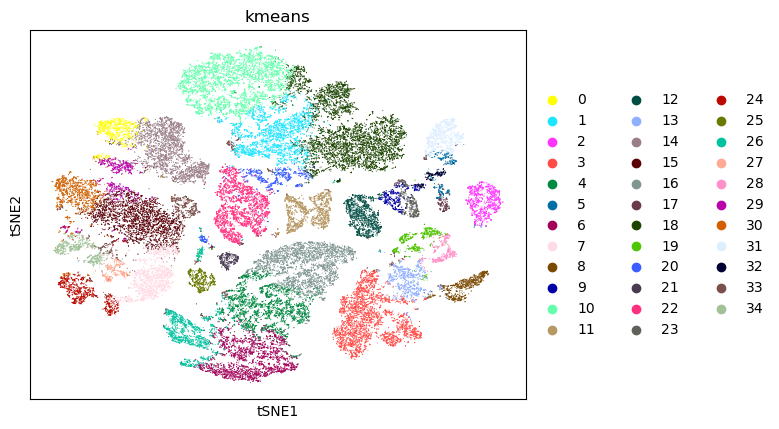

CPU times: user 619 ms, sys: 160 ms, total: 779 ms
Wall time: 578 ms


In [20]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

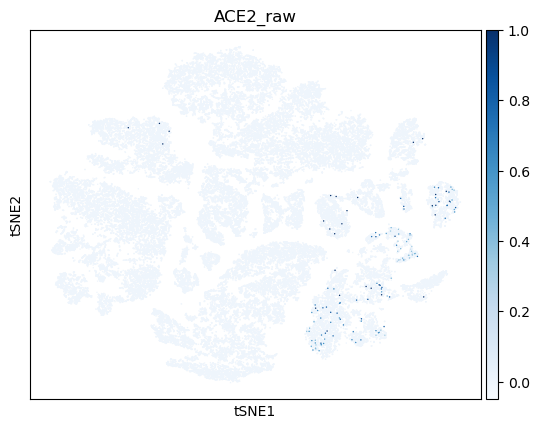

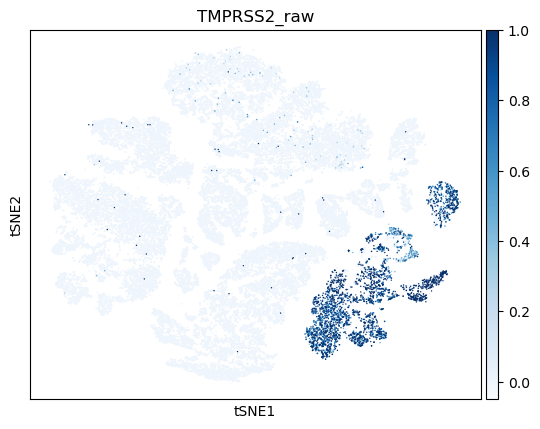

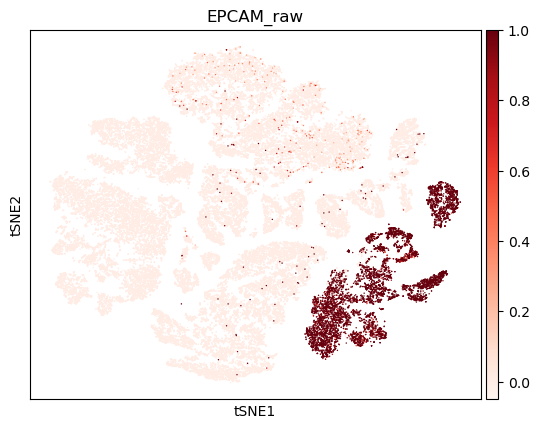

CPU times: user 658 ms, sys: 504 ms, total: 1.16 s
Wall time: 561 ms


In [21]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Graph clustering

In [22]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 1min 16s, sys: 48.7 s, total: 2min 5s
Wall time: 19.6 s


In [23]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 6min 1s, sys: 9min 5s, total: 15min 6s
Wall time: 26.8 s


In [24]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 7.51 s, sys: 44.5 ms, total: 7.56 s
Wall time: 7.54 s


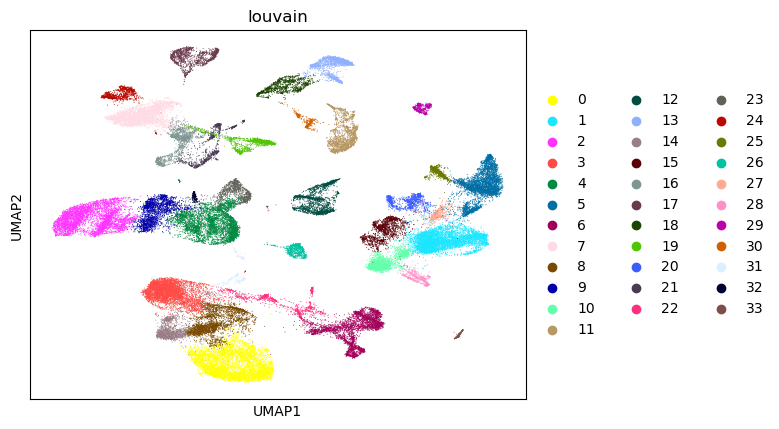

CPU times: user 588 ms, sys: 128 ms, total: 716 ms
Wall time: 516 ms


In [25]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

In [26]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 5.91 s, sys: 47.9 ms, total: 5.96 s
Wall time: 5.96 s


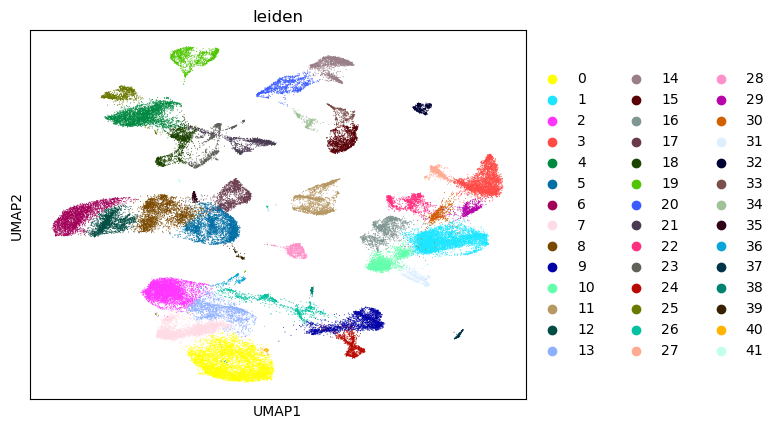

CPU times: user 622 ms, sys: 169 ms, total: 791 ms
Wall time: 590 ms


In [27]:
%%time
# Plot
sc.pl.umap(adata, color=["leiden"])

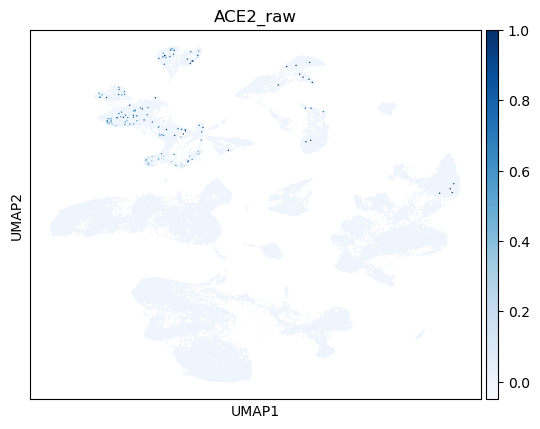

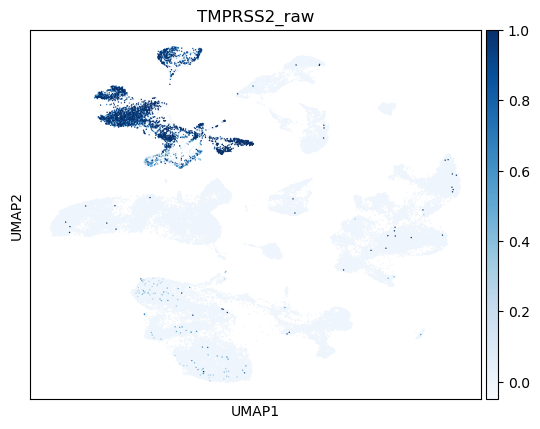

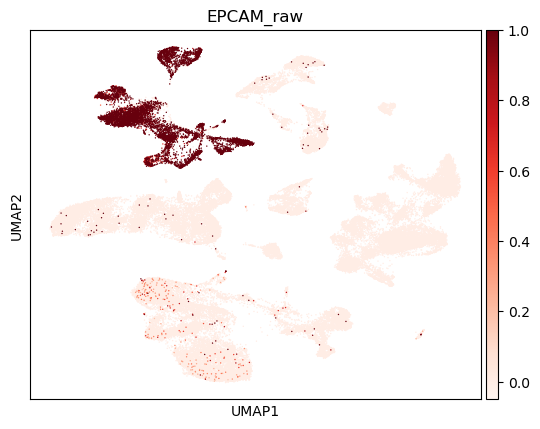

CPU times: user 648 ms, sys: 483 ms, total: 1.13 s
Wall time: 530 ms


In [28]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

## Differential expression analysis

In [29]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=ranking_n_top_genes, groups='all', reference='rest', method='logreg')

CPU times: user 5h 8min 57s, sys: 4h 27min 12s, total: 9h 36min 9s
Wall time: 4min 34s


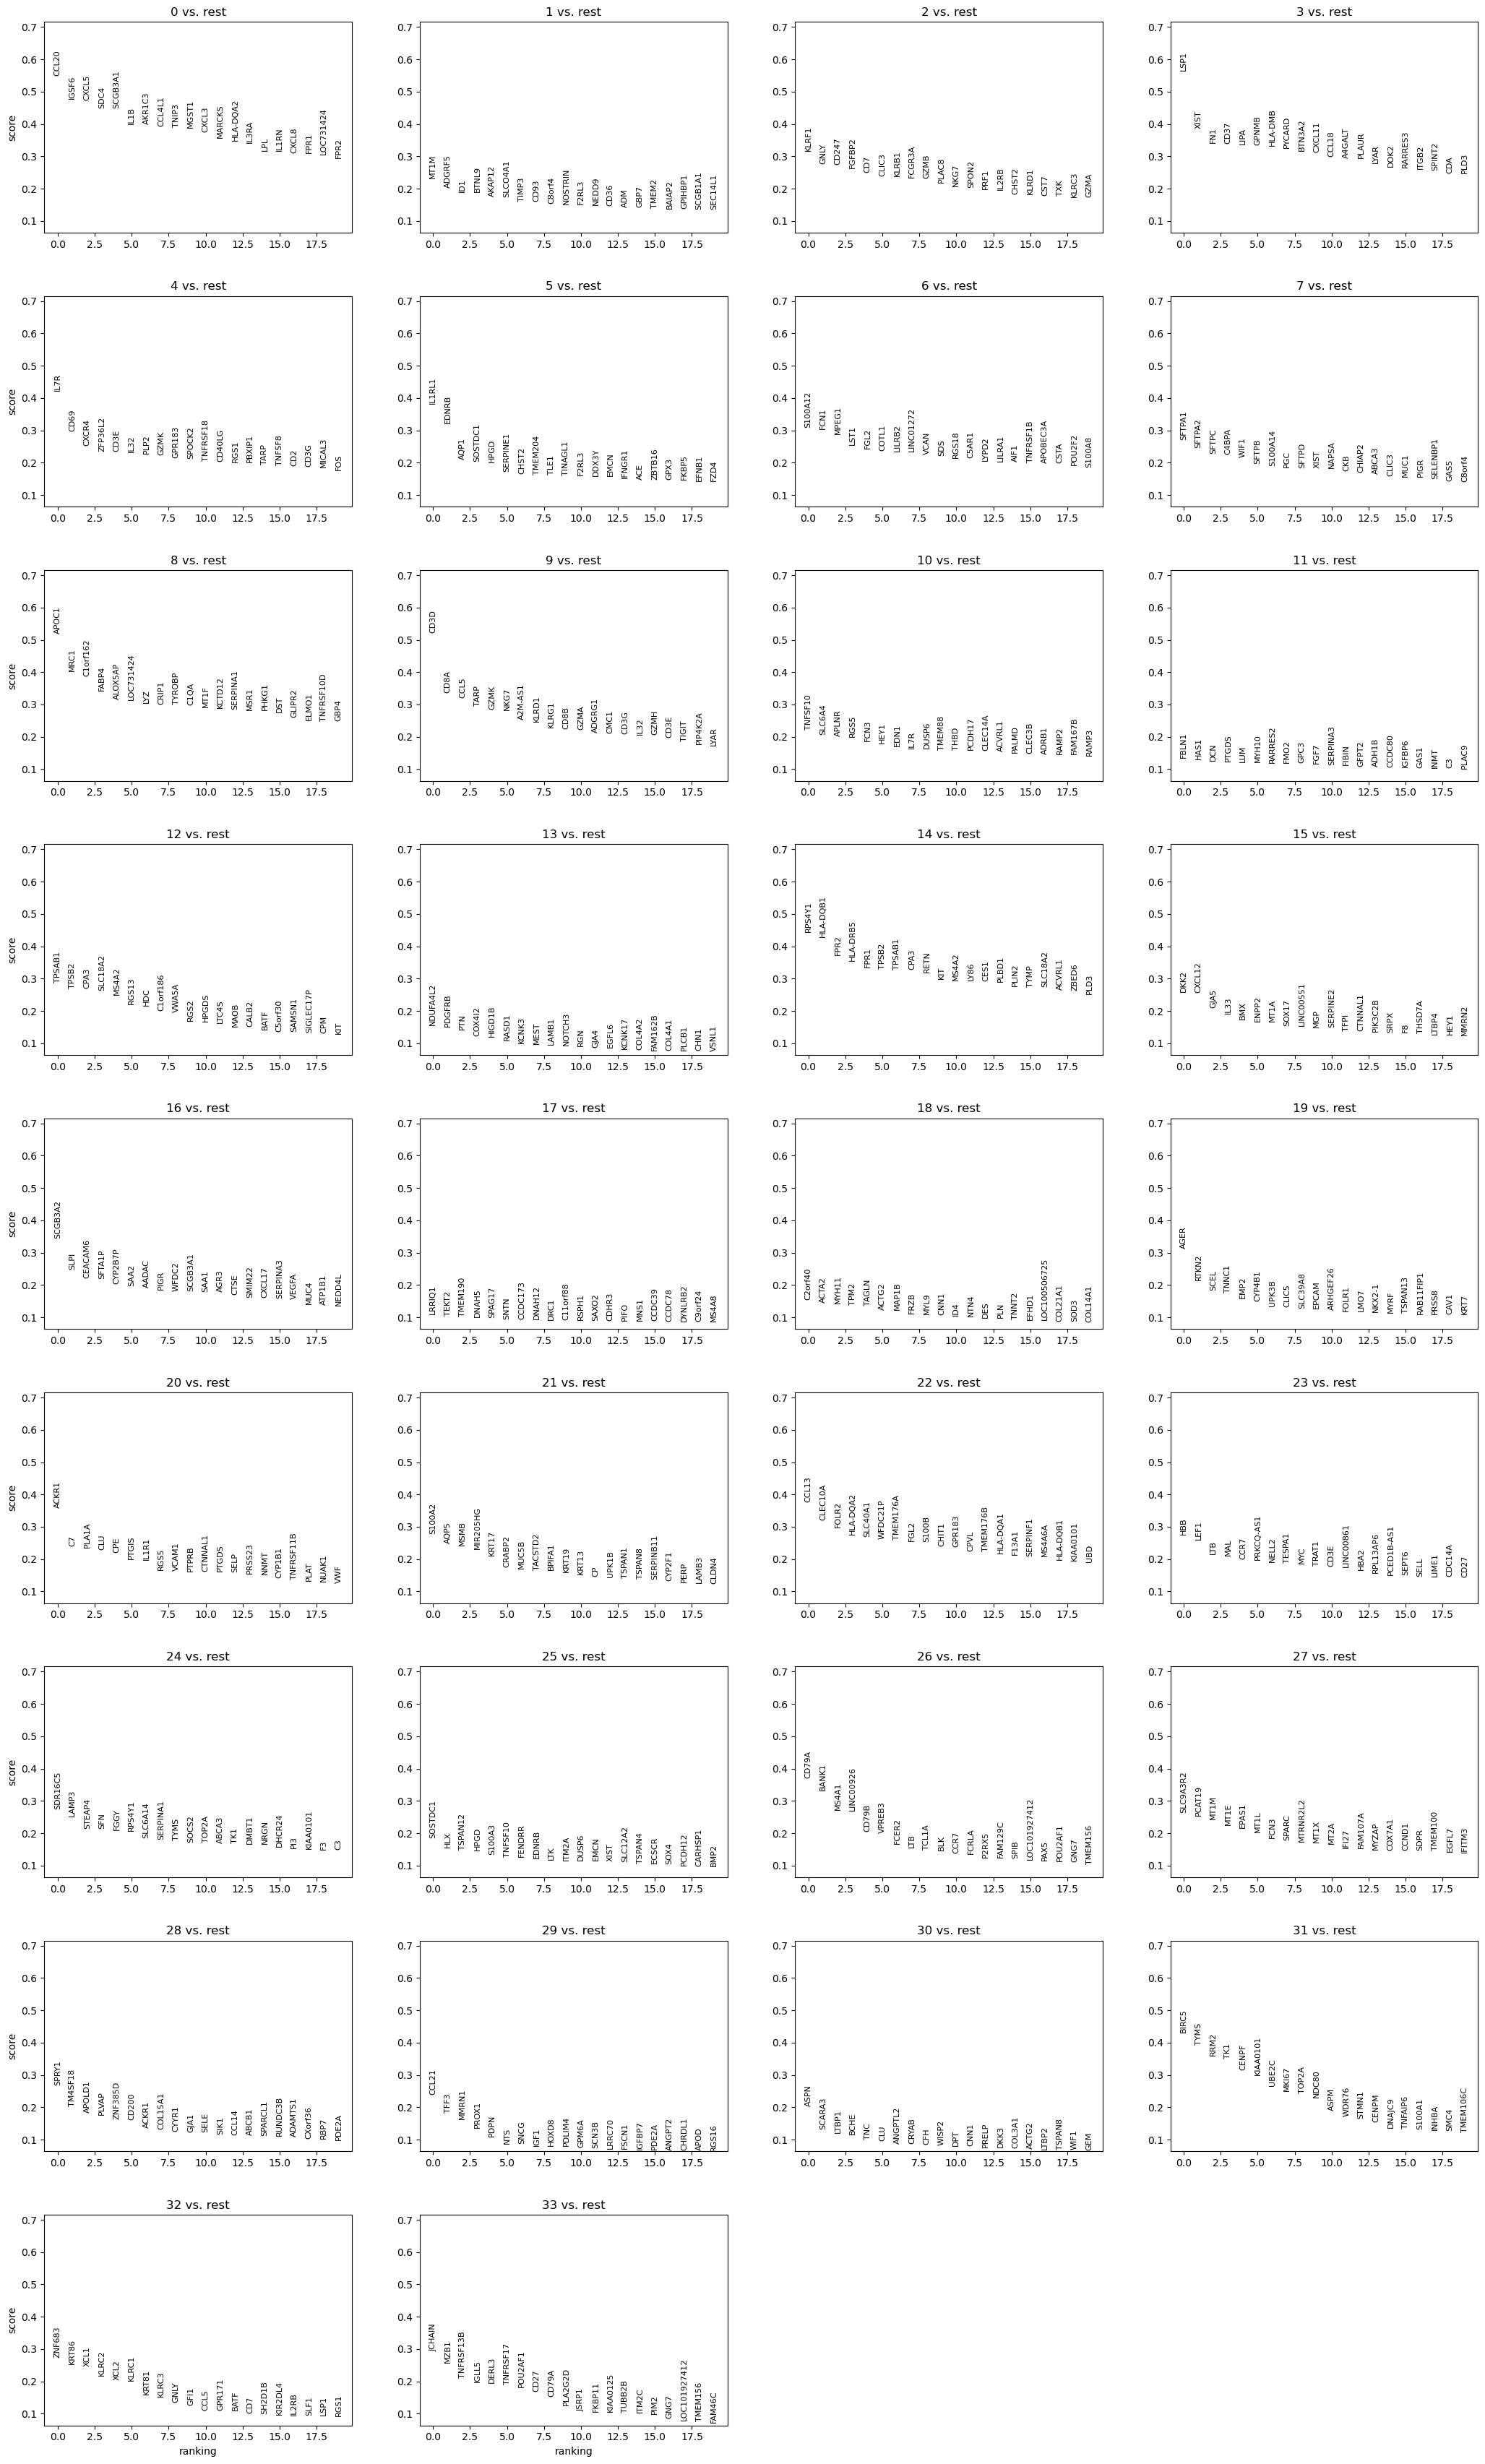

CPU times: user 4.93 s, sys: 4.31 s, total: 9.24 s
Wall time: 3.61 s


In [30]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create zoomed-in view

In [31]:
reanalysis_start = time.time()

In [32]:
%%time

adata = adata[adata.obs["EPCAM_raw"] > 0.0, :]
print(adata.X.shape)

(7958, 5000)
CPU times: user 46.8 ms, sys: 19.1 ms, total: 65.8 ms
Wall time: 65.7 ms


In [33]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 4min 55s, sys: 2min 53s, total: 7min 48s
Wall time: 11.6 s


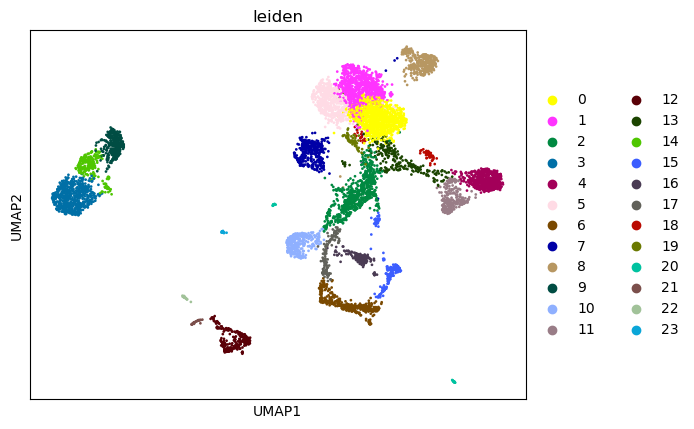

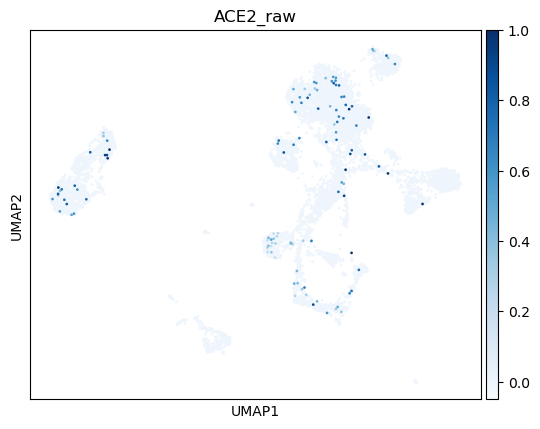

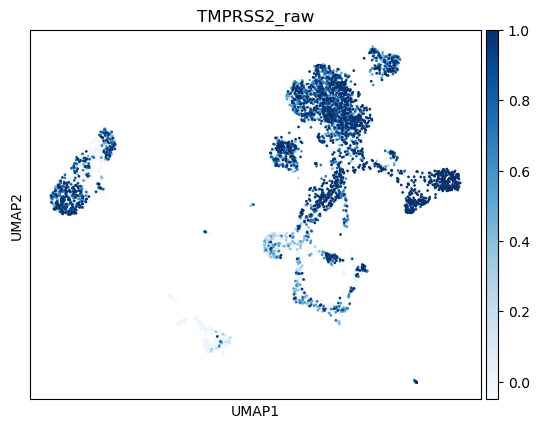

CPU times: user 529 ms, sys: 381 ms, total: 910 ms
Wall time: 443 ms


In [34]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 12.104302406311035


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 515.0031383037567
